In [11]:
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table

def angular_separation_arcmin(ra1, dec1, ra2, dec2):
    """
    Compute angular separation between two points (RA/Dec, degrees) in arcminutes.
    All inputs and output are floats.
    """
    c1 = SkyCoord(ra1, dec1, unit='deg')
    c2 = SkyCoord(ra2, dec2, unit='deg')
    sep = c1.separation(c2)
    return sep.arcminute  # Output: float, arcminutes

def beam_scaling(beam_ra, beam_dec, star_ra, star_dec, fwhm_arcmin):
    """
    Calculate angular separation and Gaussian beam scaling factor for a star.
    All coordinates in degrees, FWHM and output in arcminutes.
    Returns: (theta_arcmin: angular separation between star and beam center, scaling_factor: normalized sensitivity of the star, 
    eirp_boost: how many times larger the EIRPmin of the star must be than the beam's center)
    """
    theta_arcmin = angular_separation_arcmin(beam_ra, beam_dec, star_ra, star_dec)
    exponent = -4 * np.log(2) * (theta_arcmin / fwhm_arcmin)**2
    scaling_factor = np.exp(exponent)
    eirp_boost = np.where(scaling_factor > 0, 1.0 / scaling_factor, np.inf)
    return theta_arcmin, scaling_factor, eirp_boost

def process_beam_astropy_vectorized(beam_ra, beam_dec, fwhm_arcmin, catalog_df):
    """
    Add beam sensitivity columns to existing DataFrame
    Inputs:
        beam_ra, beam_dec: Beam center (degrees)
        fwhm_arcmin: Beam width (arcminutes)
        catalog_df: DataFrame containing 'ra', 'dec'
    Returns: Modified DataFrame with new columns using SkyCoord
    Vectorized processing for large catalogs.
    """
    # Extract RA/Dec as numpy arrays
    star_ras = catalog_df['ra'].to_numpy()
    star_decs = catalog_df['dec'].to_numpy()
    
    # Compute metrics in bulk
    theta, scaling, eirp = beam_scaling(
        beam_ra, beam_dec, star_ras, star_decs, fwhm_arcmin
    )
    
    # Add results to DataFrame (no copying)
    catalog_df = catalog_df.copy()
    catalog_df['theta_arcmin'] = theta
    catalog_df['scaling_factor'] = scaling
    catalog_df['eirp_boost'] = eirp
    
    return catalog_df

In [12]:
import pandas as pd
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
from astroquery.ipac.ned import Ned

def query_ned(beam_ra, beam_dec, fwhm_arcmin):
    def angular_separation_arcmin(ra1, dec1, ra2, dec2):
        """
        Compute angular separation between two points (RA/Dec, degrees) in arcminutes.
        All inputs and output are floats.
        """
        c1 = SkyCoord(ra1, dec1, unit='deg')
        c2 = SkyCoord(ra2, dec2, unit='deg')
        sep = c1.separation(c2)
        return sep.arcminute  # Output: float, arcminutes

    def beam_scaling(beam_ra, beam_dec, star_ra, star_dec, fwhm_arcmin):
        """
        Calculate angular separation and Gaussian beam scaling factor for a star.
        All coordinates in degrees, FWHM and output in arcminutes.
        Returns: (theta_arcmin: angular separation between star and beam center, scaling_factor: normalized sensitivity of the star, 
        eirp_boost: how many times larger the EIRPmin of the star must be than the beam's center)
        """
        theta_arcmin = angular_separation_arcmin(beam_ra, beam_dec, star_ra, star_dec)
        exponent = -4 * np.log(2) * (theta_arcmin / fwhm_arcmin)**2
        scaling_factor = np.exp(exponent)
        eirp_boost = np.where(scaling_factor > 0, 1.0 / scaling_factor, np.inf)
        return theta_arcmin, scaling_factor, eirp_boost
    
    def process_beam_astropy_vectorized(beam_ra, beam_dec, fwhm_arcmin, catalog_df):
        """
        Add beam sensitivity columns to existing DataFrame
        Inputs:
            beam_ra, beam_dec: Beam center (degrees)
            fwhm_arcmin: Beam width (arcminutes)
            catalog_df: DataFrame containing 'ra', 'dec'
        Returns: Modified DataFrame with new columns using SkyCoord
        Vectorized processing for large catalogs.
        """
        # Extract RA/Dec as numpy arrays
        star_ras = catalog_df['ra'].to_numpy()
        star_decs = catalog_df['dec'].to_numpy()
        
        # Compute metrics in bulk
        theta, scaling, eirp = beam_scaling(
            beam_ra, beam_dec, star_ras, star_decs, fwhm_arcmin
        )
        
        # Add results to DataFrame (no copying)
        catalog_df = catalog_df.copy()
        catalog_df['theta_arcmin'] = theta
        catalog_df['scaling_factor'] = scaling
        catalog_df['eirp_boost'] = eirp
        
        return catalog_df
    result_table = Ned.query_region(SkyCoord(ra=beam_ra*u.deg, dec=beam_dec*u.deg), radius=(fwhm_arcmin/2.0)*u.arcmin)
    df = result_table.to_pandas()
    df = df.rename(columns={"RA": "ra", "DEC": "dec"})
    return process_beam_astropy_vectorized(beam_ra, beam_dec, fwhm_arcmin, df)

In [25]:
from astroquery.ipac.ned import Ned
from astropy.coordinates import SkyCoord
import astropy.units as u
import pandas as pd
import numpy as np
from tqdm import tqdm

def query_ned_with_redshifts(beam_ra, beam_dec, fwhm_arcmin):
    coord = SkyCoord(ra=beam_ra*u.deg, dec=beam_dec*u.deg)
    radius = (fwhm_arcmin / 2.0) * u.arcmin
    result_table = Ned.query_region(coord, radius=radius)
    
    df = result_table.to_pandas()
    df = df.rename(columns={"RA": "ra", "DEC": "dec"})
    
    # Add an empty Redshift column first
    df["Redshift"] = np.nan
    
    print(f"Querying redshifts for {len(df)} objects...")
    
    for i, name in tqdm(enumerate(df["Object Name"]), total=len(df)):
        try:
            object_table = Ned.query_object(name)
            if "Redshift" in object_table.colnames:
                z_val = object_table["Redshift"][0]
                if not np.ma.is_masked(z_val):
                    df.at[i, "Redshift"] = z_val
        except Exception as e:
            # Sometimes NED throws HTTP or missing record errors
            continue
    
    return process_beam_astropy_vectorized(beam_ra, beam_dec, fwhm_arcmin, df)


In [13]:
# Load the VOTable
votable_path = "356616_observations_288315_unique_280820.vot"
data_table = Table.read(votable_path, format="votable")
df = data_table.to_pandas()
df

,source_id,ra,ra_error,dec,dec_error,parallax,parallax_over_error,pmra,pmra_error,pmdec,...,r_hi,r_len,target_observed_by,source_observed_by,fwhm_arcmin,offset_deg,offset_arcmin,telescope_response_gaussian,min_detectable_EIRP,price_target_
0,5278042880077383040,124.373564,0.531406,-61.916283,0.577067,191.530069,317.248718,-156.445708,1.257197,1099.603065,...,5.237054,854.145623,Parkes 10-cm,Parkes 10-cm,6.4,0.004946,0.296757,0.994057,9.979345e+10,True
1,5278019446732658176,124.323083,0.683469,-61.933165,0.722185,0.288692,0.386957,-9.208477,1.665850,4.106262,...,3424.169938,852.574779,Parkes 10-cm,Parkes 10-cm,6.4,0.053314,3.198850,0.500249,2.571122e+16,False
2,5278042914437037440,124.321704,0.017173,-61.921527,0.019508,0.306640,15.678685,1.455955,0.039321,-3.939431,...,3149.749330,852.831089,Parkes 10-cm,Parkes 10-cm,6.4,0.053294,3.197619,0.500516,6.391667e+16,False
3,5277995665498104576,124.405225,0.123812,-61.964518,0.137092,0.162447,1.190629,2.031666,0.288846,-0.058157,...,4666.506808,853.656804,Parkes 10-cm,Parkes 10-cm,6.4,0.052973,3.178368,0.504692,7.781783e+16,False
4,5277996009096662912,124.427643,0.465830,-61.920097,0.409031,0.134454,0.301610,-3.008525,1.080743,5.900701,...,3767.438101,855.297497,Parkes 10-cm,Parkes 10-cm,6.4,0.052656,3.159362,0.508823,3.617772e+16,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356611,5353625817648324352,162.327898,0.169651,-53.323989,0.188827,0.002797,0.012486,-7.121278,0.332859,4.258981,...,6063.476843,1216.497976,Parkes 10-cm,Parkes 10-cm,6.4,0.004614,0.276850,0.994825,5.451843e+16,False
356612,5353625847691839616,162.331233,0.148051,-53.317264,0.161793,0.107848,0.543369,-6.472833,0.280615,0.680678,...,5731.854286,1216.642346,Parkes 10-cm,Parkes 10-cm,6.4,0.003272,0.196336,0.997394,4.785815e+16,False
356613,5353625817648467840,162.328145,0.401868,-53.322196,0.451638,-0.629335,-1.170949,-5.444157,0.841270,1.893667,...,5795.023651,1216.522702,Parkes 10-cm,Parkes 10-cm,6.4,0.002810,0.168584,0.998078,4.466139e+16,False
356614,5353625847691839488,162.328315,0.037486,-53.318426,0.041577,0.150904,3.040733,-4.872873,0.072231,1.066499,...,6255.618265,1216.567137,Parkes 10-cm,Parkes 10-cm,6.4,0.001153,0.069207,0.999676,8.723952e+16,False


In [14]:
df_small = df.loc[[0, 500, 5000, 50000, 100000, 200000, 300000], ["ra", "dec", "fwhm_arcmin", "r_est"]].copy()
df_small

,ra,dec,fwhm_arcmin,r_est
0,124.373564,-61.916283,6.4,5.220425
500,235.157257,-50.986211,6.4,3569.674987
5000,6.639102,-41.840455,6.4,1038.977856
50000,337.162703,18.968371,8.4,2186.465647
100000,104.347052,-24.647317,6.4,3370.492664
200000,264.242801,-44.312320,5.5,3672.485895
300000,296.382669,33.565181,5.5,2411.655322


In [15]:
# from astroquery.ipac.ned import Ned
# import astropy.units as u
# from astropy import coordinates
# co = coordinates.SkyCoord(ra=56.38, dec=38.43,
#                           unit=(u.deg, u.deg), frame='fk4')
# result_table = Ned.query_region(co, radius=0.1 * u.deg, equinox='B1950.0')
# print(result_table)
# result_table.info()


In [42]:
region_7 = query_ned(296.382669, 33.565181, 5.5)
region_7.Redshift.notnull().sum()

np.int64(0)

In [43]:
region_7

,No.,Object Name,ra,dec,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations,theta_arcmin,scaling_factor,eirp_boost
0,1,2MASS J19451894+3333376,296.32894,33.56045,IrS,NaN,NaN,,,2.702,0,0,4,1,0,0,0,2.701235,0.512332,1.951859
1,2,WISEA J194518.97+333353.4,296.32904,33.56485,IrS,NaN,NaN,,,2.681,0,0,18,2,0,0,0,2.681284,0.517400,1.932742
2,3,2MASS J19451900+3333209,296.32918,33.55583,IrS,NaN,NaN,,,2.733,0,0,4,1,0,0,0,2.732571,0.504398,1.982560
3,4,WISEA J194519.29+333423.2,296.33040,33.57313,IrS,NaN,NaN,,,2.657,0,0,18,2,0,0,0,2.656260,0.523773,1.909226
4,5,2MASS J19451932+3333363,296.33053,33.56010,IrS,NaN,NaN,,,2.625,0,0,6,1,0,0,0,2.624555,0.531872,1.880150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,483,WISEA J194543.71+333454.2,296.43216,33.58174,IrS,NaN,NaN,,,2.666,0,0,18,2,0,0,0,2.666126,0.521258,1.918437
483,484,WISEA J194544.19+333310.1,296.43412,33.55289,IrS,NaN,NaN,,,2.676,0,0,18,2,0,0,0,2.676116,0.518714,1.927843
484,485,2MASS J19454457+3333167,296.43574,33.55464,IrS,NaN,NaN,,,2.727,0,0,5,1,0,0,0,2.727803,0.505603,1.977835
485,486,2MASS J19454461+3334072,296.43588,33.56869,IrS,NaN,NaN,,,2.668,0,0,6,1,0,0,0,2.668572,0.520635,1.920732


In [26]:
query_ned_with_redshifts(296.382669, 33.565181, 5.5)

Querying redshifts for 487 objects...


100%|███████████████████████████████████████████████████████████████████████████| 487/487 [04:14<00:00,  1.91it/s]


,No.,Object Name,ra,dec,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations,theta_arcmin,scaling_factor,eirp_boost
0,1,2MASS J19451894+3333376,296.32894,33.56045,IrS,NaN,NaN,,,2.702,0,0,4,1,0,0,0,2.701235,0.512332,1.951859
1,2,WISEA J194518.97+333353.4,296.32904,33.56485,IrS,NaN,NaN,,,2.681,0,0,18,2,0,0,0,2.681284,0.517400,1.932742
2,3,2MASS J19451900+3333209,296.32918,33.55583,IrS,NaN,NaN,,,2.733,0,0,4,1,0,0,0,2.732571,0.504398,1.982560
3,4,WISEA J194519.29+333423.2,296.33040,33.57313,IrS,NaN,NaN,,,2.657,0,0,18,2,0,0,0,2.656260,0.523773,1.909226
4,5,2MASS J19451932+3333363,296.33053,33.56010,IrS,NaN,NaN,,,2.625,0,0,6,1,0,0,0,2.624555,0.531872,1.880150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,483,WISEA J194543.71+333454.2,296.43216,33.58174,IrS,NaN,NaN,,,2.666,0,0,18,2,0,0,0,2.666126,0.521258,1.918437
483,484,WISEA J194544.19+333310.1,296.43412,33.55289,IrS,NaN,NaN,,,2.676,0,0,18,2,0,0,0,2.676116,0.518714,1.927843
484,485,2MASS J19454457+3333167,296.43574,33.55464,IrS,NaN,NaN,,,2.727,0,0,5,1,0,0,0,2.727803,0.505603,1.977835
485,486,2MASS J19454461+3334072,296.43588,33.56869,IrS,NaN,NaN,,,2.668,0,0,6,1,0,0,0,2.668572,0.520635,1.920732


In [17]:
region_7.columns

Index(['No.', 'Object Name', 'ra', 'dec', 'Type', 'Velocity', 'Redshift',
       'Redshift Flag', 'Magnitude and Filter', 'Separation', 'References',
       'Notes', 'Photometry Points', 'Positions', 'Redshift Points',
       'Diameter Points', 'Associations', 'theta_arcmin', 'scaling_factor',
       'eirp_boost'],
      dtype='object')

In [18]:
region_7.Redshift.notnull().sum()

np.int64(0)

In [19]:
from astroquery.ipac.ned import Ned
import astropy.units as u
from astropy import coordinates
co = coordinates.SkyCoord(ra=296.382669, dec=33.565181,
                          unit=(u.deg, u.deg), frame='icrs')
result_table = Ned.query_region(co, radius=2.75 * u.arcmin)
redshifts = []
for row in result_table:
    object_name = row['Object Name']
    try:
        # Query the 'objdir' table for redshift data (adjust if the table name is different)
        obj_data = Ned.get_table(object_name, table='NEDTAP.objdir') # Changed 'redshifts' to 'objdir'
        if obj_data is not None and 'z' in obj_data.colnames: # Adjusted column name to 'z'
            redshifts.append(obj_data['z'][0])  # Append the redshift value
        else:
            redshifts.append(None)  # Append None if redshift data is not available
    except Exception as e:
        print(f"Error querying {object_name}: {e}")
        redshifts.append(None)  # Append None in case of an error

result_table['Redshift'] = redshifts
result_table


Error querying 2MASS J19451894+3333376: 'NEDTAP.objdir'
Error querying WISEA J194518.97+333353.4: 'NEDTAP.objdir'
Error querying 2MASS J19451900+3333209: 'NEDTAP.objdir'
Error querying WISEA J194519.29+333423.2: 'NEDTAP.objdir'
Error querying 2MASS J19451932+3333363: 'NEDTAP.objdir'
Error querying 2MASS J19451947+3334112: 'NEDTAP.objdir'
Error querying 2MASS J19451951+3333078: 'NEDTAP.objdir'
Error querying WISEA J194519.51+333324.8: 'NEDTAP.objdir'
Error querying 2MASS J19451951+3333254: 'NEDTAP.objdir'
Error querying WISEA J194519.54+333333.2: 'NEDTAP.objdir'
Error querying 2MASS J19451961+3333325: 'NEDTAP.objdir'
Error querying 2MASS J19452010+3334512: 'NEDTAP.objdir'
Error querying 2MASS J19452043+3333370: 'NEDTAP.objdir'
Error querying 2MASS J19452053+3333002: 'NEDTAP.objdir'
Error querying 2MASS J19452054+3334022: 'NEDTAP.objdir'
Error querying WISEA J194520.58+333405.7: 'NEDTAP.objdir'
Error querying 2MASS J19452062+3334063: 'NEDTAP.objdir'
Error querying WISEA J194520.63+333312

No.,Object Name,RA,DEC,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
,,degrees,degrees,,km / s,,,,arcmin,,,,,,,
int32,str30,float64,float64,object,float64,object,object,object,float64,int32,int32,int32,int32,int32,int32,int32
1,2MASS J19451894+3333376,296.32894,33.56045,IrS,--,None,,,2.702,0,0,4,1,0,0,0
2,WISEA J194518.97+333353.4,296.32904,33.56485,IrS,--,None,,,2.681,0,0,18,2,0,0,0
3,2MASS J19451900+3333209,296.32918,33.55583,IrS,--,None,,,2.733,0,0,4,1,0,0,0
4,WISEA J194519.29+333423.2,296.3304,33.57313,IrS,--,None,,,2.657,0,0,18,2,0,0,0
5,2MASS J19451932+3333363,296.33053,33.5601,IrS,--,None,,,2.625,0,0,6,1,0,0,0
6,2MASS J19451947+3334112,296.33115,33.56981,IrS,--,None,,,2.591,0,0,6,1,0,0,0
7,2MASS J19451951+3333078,296.33131,33.55219,IrS,--,None,,,2.684,0,0,6,1,0,0,0
8,WISEA J194519.51+333324.8,296.33132,33.55691,IrS,--,None,,,2.615,0,0,12,1,0,0,0


In [20]:
from astroquery.vo.tap import TAPPlus

tap_service = TAPPlus(url='https://ned.ipac.caltech.edu/tap')  # Replace with the correct TAP service URL if necessary

query = "SELECT ra, dec, z FROM NEDTAP.objdir WHERE ra > 296.38 - 2.75/60 and ra < 296.38 + 2.75/60 and dec > 33.56 - 2.75/60 and dec < 33.56 + 2.75/60" # Example ADQL query for a region
job = tap_service.launch_job(query)
results = job.get_results()
results


ModuleNotFoundError: No module named 'astroquery.vo'

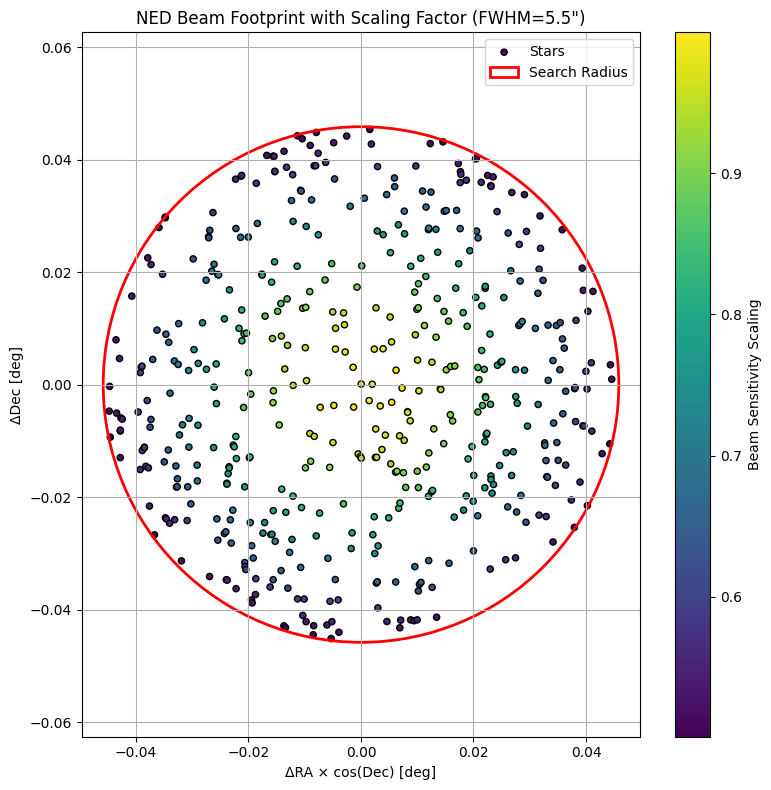

In [183]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

ra_center = 296.382669
dec_center = 33.565181
fwhm_arcmin = 5.5
radius_deg = (fwhm_arcmin / 2.0) / 60.0
cos_dec = np.cos(np.radians(dec_center))

# Coordinate transformation
scaled_ra = (region_7['ra'] - ra_center) * cos_dec
scaled_dec = region_7['dec'] - dec_center

# Plot with scaling_factor as color
plt.figure(figsize=(8, 8))
sc = plt.scatter(scaled_ra, scaled_dec, c=region_7['scaling_factor'],
                 cmap='viridis', s=20, edgecolor='k', label='Stars')

# Add beam circle
circle = Circle((0, 0), radius_deg, edgecolor='red', facecolor='none', linewidth=2, label='Search Radius')
plt.gca().add_patch(circle)

plt.xlabel('ΔRA × cos(Dec) [deg]')
plt.ylabel('ΔDec [deg]')
plt.title(f'NED Beam Footprint with Scaling Factor (FWHM={fwhm_arcmin}")')
plt.gca().set_aspect('equal', adjustable='datalim')
plt.colorbar(sc, label='Beam Sensitivity Scaling')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [73]:
df_small

,ra,dec,fwhm_arcmin,r_est
0,124.373564,-61.916283,6.4,5.220425
500,235.157257,-50.986211,6.4,3569.674987
5000,6.639102,-41.840455,6.4,1038.977856
50000,337.162703,18.968371,8.4,2186.465647
100000,104.347052,-24.647317,6.4,3370.492664
200000,264.242801,-44.312320,5.5,3672.485895
300000,296.382669,33.565181,5.5,2411.655322


In [74]:
region_1 = query_ned(124.373564, -61.916283, 6.4)
region_1

,No.,Object Name,ra,dec,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations,theta_arcmin,scaling_factor,eirp_boost
0,1,WISEA J081704.86-615449.0,124.27029,-61.91363,IrS,NaN,NaN,,,2.922,0,0,12,1,0,0,0,2.921509,0.561159,1.782025
1,2,WISEA J081704.92-615438.2,124.27052,-61.91063,IrS,NaN,NaN,,,2.931,0,0,12,1,0,0,0,2.930510,0.559162,1.788390
2,3,WISEA J081705.70-615438.1,124.27376,-61.91059,IrS,NaN,NaN,,,2.840,0,0,12,1,0,0,0,2.839910,0.579304,1.726208
3,4,WISEA J081705.97-615543.9,124.27489,-61.92887,IrS,NaN,NaN,,,2.887,0,0,18,2,0,0,0,2.887067,0.568810,1.758055
4,5,WISEA J081706.52-615513.6,124.27718,-61.92046,IrS,NaN,NaN,,,2.734,0,0,12,1,0,0,0,2.733757,0.602976,1.658440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,231,WISEA J081754.10-615443.3,124.47543,-61.91203,IrS,NaN,NaN,,,2.889,0,0,12,1,0,0,0,2.888766,0.568433,1.759223
231,232,WISEA J081754.71-615542.0,124.47797,-61.92835,IrS,NaN,NaN,,,3.036,0,0,12,1,0,0,0,3.036029,0.535833,1.866252
232,233,WISEA J081755.12-615352.9,124.47969,-61.89805,IrS,NaN,NaN,,,3.192,0,0,16,2,0,0,0,3.191826,0.501771,1.992939
233,234,WISEA J081755.15-615514.0,124.47982,-61.92056,IrS,NaN,NaN,,,3.012,0,0,18,2,0,0,0,3.012013,0.541128,1.847993


In [79]:
from astroquery.ipac.ned import Ned
import astropy.units as u
from astropy import coordinates
co = coordinates.SkyCoord(ra=56.38, dec=38.43,
                          unit=(u.deg, u.deg), frame='icrs')
result_table = Ned.query_region(co, radius=5 * u.arcmin, equinox='B1950.0')
redshifts = []
for row in result_table:
    object_name = row['Object Name']  # Replace 'Object Name' with the actual column name for the object name in your result_table
    obj_data = Ned.query_object(object_name)
    if obj_data is not None and 'Redshift' in obj_data.colnames:
        redshifts.append(obj_data['Redshift'][0])  # Assuming redshift is in the first row of obj_data
    else:
        redshifts.append(None)  # Append None if redshift is not found
result_table['Redshift'] = redshifts
result_table

KeyboardInterrupt: 

In [22]:
def calculate_eirpmin_log_ned(df, fmin):
    df = df.copy()
    # Convert redshift to distance if needed
    H0 = 70  # km/s/Mpc
    c = 299792.458  # km/s
    df['distance'] = (df['z'] * c) / H0  # Mpc
    df['distance'] *= 1e6  # Convert Mpc to pc
    log_4pi = np.log10(4 * np.pi)
    df.loc[df['distance'] <= 0, 'distance'] = np.nan
    d_m = df['distance'].to_numpy() * 3.086e16  # pc to m
    eirp_boost = df['eirp_boost'].to_numpy()
    df['logEIRPmin'] = log_4pi + 2 * np.log10(d_m) + np.log10(fmin) + np.log10(eirp_boost)
    return df

In [23]:
def analyze_shells_with_uncertainty_cumulative_log_ned(df, log_eirp_shells, fmin, nu_rel):
    results = []
    for log_shell_val in log_eirp_shells:
        shell_val = 10**log_shell_val
        n_stars = np.sum(df['logEIRPmin'] <= log_shell_val)
        n_stars_err = np.sqrt(n_stars) # if n_stars > 0 else np.nan
        cwtfm = (shell_val / 1e13) * (0.5 / nu_rel) * (1000 / n_stars) if n_stars > 0 else np.nan
        cwtfm_err = cwtfm * (n_stars_err / n_stars) if n_stars > 0 else np.nan
        results.append({
            'EIRPmin_shell': shell_val,
            'n_stars': n_stars,
            'n_stars_err': n_stars_err,
            'CWTFM': cwtfm,
            'CWTFM_err': cwtfm_err
        })
    return pd.DataFrame(results)

In [24]:
import numpy as np
import pandas as pd

def angular_separation_arcmin_vectorized(ra1, dec1, ra2, dec2):
    """Calculate angular separation in arcminutes using the Haversine formula."""
    ra1_rad = np.radians(ra1)
    dec1_rad = np.radians(dec1)
    ra2_rad = np.radians(ra2)
    dec2_rad = np.radians(dec2)
    dra = ra2_rad - ra1_rad
    ddec = dec2_rad - dec1_rad
    a = np.sin(ddec/2)**2 + np.cos(dec1_rad) * np.cos(dec2_rad) * np.sin(dra/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return np.degrees(c) * 60  # arcminutes

def beam_scaling_vectorized(beam_ra, beam_dec, star_ras, star_decs, fwhm_arcmin):
    theta_arcmin = angular_separation_arcmin_vectorized(beam_ra, beam_dec, star_ras, star_decs)
    exponent = -4 * np.log(2) * (theta_arcmin / fwhm_arcmin)**2
    scaling_factor = np.exp(exponent)
    eirp_boost = np.where(scaling_factor > 0, 1.0 / scaling_factor, np.inf)
    return theta_arcmin, scaling_factor, eirp_boost

def calculate_eirpmin_log_ned(df, fmin):
    df = df.copy()
    log_4pi = np.log10(4 * np.pi)
    if 'distance' in df.columns:
        df.loc[df['distance'] <= 0, 'distance'] = np.nan
        d_m = df['distance'].to_numpy() * 3.086e16  # pc to m
        eirp_boost = df['eirp_boost'].to_numpy()
        df['logEIRPmin'] = log_4pi + 2 * np.log10(d_m) + np.log10(fmin) + np.log10(eirp_boost)
    else:
        df['logEIRPmin'] = np.nan
    return df

def analyze_shells_with_uncertainty_cumulative_log_ned(df, log_eirp_shells, fmin, nu_rel):
    results = []
    for log_shell_val in log_eirp_shells:
        shell_val = 10**log_shell_val
        n_stars = np.sum(df['logEIRPmin'] <= log_shell_val)
        n_stars_err = np.sqrt(n_stars) if n_stars > 0 else np.nan
        cwtfm = (shell_val / 1e13) * (0.5 / nu_rel) * (1000 / n_stars) if n_stars > 0 else np.nan
        cwtfm_err = cwtfm * (n_stars_err / n_stars) if n_stars > 0 else np.nan
        results.append({
            'logEIRPmin_shell': log_shell_val,
            'EIRPmin_shell': shell_val,
            'n_stars': n_stars,
            'n_stars_err': n_stars_err,
            'CWTFM': cwtfm,
            'CWTFM_err': cwtfm_err
        })
    return pd.DataFrame(results)



In [36]:
def process_ned_catalog(ned_df, beam_ra, beam_dec, fwhm_arcmin, fmin, nu_rel, log_eirp_shells=np.linspace(11, 18, 8)):
    gal_ras = ned_df['ra'].to_numpy()
    gal_decs = ned_df['dec'].to_numpy()
    theta, scaling, eirp_boost = beam_scaling_vectorized(beam_ra, beam_dec, gal_ras, gal_decs, fwhm_arcmin)
    df = ned_df.copy()
    df['theta_arcmin'] = theta
    df['scaling_factor'] = scaling
    df['eirp_boost'] = eirp_boost

    # Convert redshift to distance if needed
    if 'z' in df.columns and 'distance' not in df.columns:
        H0 = 70  # km/s/Mpc
        c = 299792.458  # km/s
        df['distance'] = df['z'] * c / H0  # Mpc
        df['distance'] *= 1e6  # Convert Mpc to pc

    df = calculate_eirpmin_log_ned(df, fmin)
    shell_results = analyze_shells_with_uncertainty_cumulative_log_ned(df, log_eirp_shells, fmin, nu_rel)
    return {'processed_catalog': df, 'shell_analysis': shell_results}


In [35]:
import matplotlib.pyplot as plt

def plot_transmitter_rate_vs_eirpmin_ned(shell_results, nu_rel=0.5):
    eirp_shells = shell_results['EIRPmin_shell'].to_numpy()
    n_stars = shell_results['n_stars'].to_numpy()
    n_stars_err = shell_results['n_stars_err'].to_numpy()

    with np.errstate(divide='ignore', invalid='ignore'):
        transmitter_rate = np.where(n_stars > 0, 1.0 / (n_stars * nu_rel), np.nan)
        n_stars_upper = n_stars + n_stars_err
        n_stars_lower = n_stars - n_stars_err
        transmitter_rate_pos = np.where(n_stars_lower > 0, 1.0 / (n_stars_lower * nu_rel), np.nan)
        transmitter_rate_neg = np.where(n_stars_upper > 0, 1.0 / (n_stars_upper * nu_rel), np.nan)
        log_eirp = np.log10(eirp_shells)
        log_transmitter_rate = np.log10(transmitter_rate)
        log_yerr_pos = np.log10(transmitter_rate_pos) - log_transmitter_rate
        log_yerr_neg = log_transmitter_rate - np.log10(transmitter_rate_neg)

    mask = np.isfinite(log_eirp) & np.isfinite(log_transmitter_rate) & (n_stars > 0)
    x = log_eirp[mask]
    y = log_transmitter_rate[mask]
    yerr = np.array([log_yerr_neg[mask], log_yerr_pos[mask]])

    if len(x) > 1:
        fit = np.polyfit(x, y, 1)
        fit_line = np.polyval(fit, x)
    else:
        fit = [np.nan, np.nan]
        fit_line = np.full_like(x, np.nan)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.errorbar(x, y, yerr=yerr, fmt='o', capsize=5, markersize=8, label='NED Shells')
    if len(x) > 1:
        ax.plot(x, fit_line, 'k-', label='Best Fit Line')
    ax.axvline(13, color='red', linestyle='--', lw=2, label='Arecibo Radar (logEIRP=13)')
    ax.axvline(17, color='red', linestyle='--', lw=2, label='Kardashev I (logEIRP=17)')
    ax.set_xlabel('log$_{10}$(EIRP$_{\\mathrm{min}}$/W)', fontsize=12)
    ax.set_ylabel('log$_{10}$(Transmitter Rate)', fontsize=12)
    ax.set_title('Log (Transmitter Rate) vs Log (EIRPmin) [NED]', fontsize=14)
    ax.set_xlim(11, 18)
    ax.set_ylim(-9, 3)
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()


In [40]:
from astroquery.ipac.ned import Ned
import astropy.units as u
result_table = Ned.query_region("3c 273", radius=0.05 * u.deg).to_pandas()
result_table

,No.,Object Name,RA,DEC,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
0,1,SSTSL2 J122855.02+020313.7,187.22925,2.05381,IrS,NaN,NaN,,,2.919,0,0,8,1,0,0,0
1,2,WISEA J122855.03+020309.1,187.22925,2.05227,*,NaN,NaN,,24.0R,2.918,1,0,24,3,0,0,0
2,3,SSTSL2 J122855.23+020341.5,187.23013,2.06154,IrS,NaN,NaN,,,2.917,0,0,7,1,0,0,0
3,4,SSTSL2 J122855.36+020346.9,187.23068,2.06304,IrS,NaN,NaN,,,2.904,0,0,7,1,0,0,0
4,5,SSTSL2 J122855.64+020239.1,187.23187,2.04421,IrS,NaN,NaN,,,2.804,0,0,8,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,863,SSTSL2 J122918.04+020334.2,187.32519,2.05950,IrS,NaN,NaN,,,2.866,0,0,8,1,0,0,0
863,864,SSTSL2 J122918.24+020330.7,187.32600,2.05854,IrS,NaN,NaN,,,2.907,0,0,8,1,0,0,0
864,865,SDSS J122918.38+020323.4,187.32660,2.05652,G,NaN,NaN,,21.8g,2.930,1,0,25,2,0,4,0
865,866,SSTSL2 J122918.52+020338.9,187.32718,2.06083,IrS,NaN,NaN,,,2.997,0,0,8,1,0,0,0


In [41]:
result_table.Redshift.notnull().sum()

np.int64(30)

In [34]:
from astroquery.ipac.ned import Ned
result_table = Ned.query_object("NGC 224")
result_table # an astropy.table.Table


No.,Object Name,RA,DEC,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
,,degrees,degrees,,km / s,,,,arcmin,,,,,,,
int32,str30,float64,float64,object,float64,float64,object,object,float64,int32,int32,int32,int32,int32,int32,int32
1,MESSIER 031,10.6848,41.26908,G,-297.0,-0.000991,SUN,4.36,--,5407,23,176,64,49,13,2


In [45]:
result_table.columns

Index(['No.', 'Object Name', 'RA', 'DEC', 'Type', 'Velocity', 'Redshift',
       'Redshift Flag', 'Magnitude and Filter', 'Separation', 'References',
       'Notes', 'Photometry Points', 'Positions', 'Redshift Points',
       'Diameter Points', 'Associations'],
      dtype='object')

# Pipeline

In [51]:
from astroquery.ipac.ned import Ned
import astropy.units as u
from astropy import coordinates
co = coordinates.SkyCoord(ra= 218.368, dec=52.9098,
                          unit=(u.deg, u.deg), frame='icrs')
result_table = Ned.query_region(co, radius=4.2 * u.arcmin)
df_region = result_table.to_pandas()
df_region = df_region[df_region.Redshift.notnull() & (df_region.Redshift < 0.05) & (df_region.Redshift > 0)]
df_region

,No.,Object Name,RA,DEC,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
10,11,Mr19:[BFW2006] 20354,218.26672,52.89396,GGroup,13985.0,0.046650,MUN,,3.787,1,0,0,1,2,0,0
42,43,WISEA J143310.89+525149.5,218.29538,52.86379,*,152.0,0.000507,SLS,18.9g,3.812,0,0,17,4,2,3,0
55,56,WHL J143313.0+525748,218.30399,52.96321,GClstr,13880.0,0.046300,SUN,,3.953,3,0,0,2,4,0,0
56,57,MLCG 1379,218.30403,52.96314,GTrpl,14180.0,0.047300,IFO,,3.949,1,0,0,1,1,0,0
57,58,MCG +09-24-014,218.30405,52.96313,G,14180.0,0.047299,SLS,16.0g,3.948,46,0,70,20,15,12,0
106,107,DESI J218.3282+52.9009,218.32830,52.90091,G,13827.0,0.046123,SLS,,1.533,0,0,0,1,1,0,0
118,119,[DRS2017] 000192,218.33830,52.87280,GGroup,13491.0,0.045000,SST,,2.467,2,0,0,1,2,0,0
158,159,WISEA J143325.87+525053.5,218.35781,52.84821,G,14117.0,0.047088,SLS,16.5g,3.714,20,0,63,6,6,10,0
292,293,WISEA J143342.42+525320.3,218.42676,52.88898,G,12868.0,0.042923,PUN,,2.467,2,0,33,6,2,2,0
296,297,SDSS J143342.88+525346.9,218.42873,52.89633,G,13727.0,0.045790,SLS,20.4g,2.342,5,0,20,3,3,4,1


# Based on Constraints on extragalactic transmitters via Breakthrough Listen observations of background sources G & S (2022)

In [149]:
import pandas as pd
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
from astroquery.ipac.ned import Ned

def batch_ned_extragalactic_pipeline(
    ra_list=None, dec_list=None, fwhm_list=None,
    sightline_df=None, n_sightlines=10, output_csv='ned_cone_search_results.csv',
    fmin=1e-26, nu_rel=0.769, H0=70.0,
    custom_n_galaxies_dict=None
):
    """
    Query NED for many sightlines, classify and tally object types, filter by redshift,
    calculate distances and EIRPmin, estimate N_stars (both MW and mass-based), and
    return tables for object types and transmitter constraints per galaxy type.

    Parameters
    ----------
    ra_list, dec_list, fwhm_list : array-like, optional
        Arrays/lists of RA (deg), Dec (deg), and FWHM (arcmin) for each sightline.
    sightline_df : pandas.DataFrame, optional
        DataFrame with columns 'ra', 'dec', 'fwhm_arcmin'. If provided, overrides arrays.
    n_sightlines : int, optional
        Number of sightlines (rows) to process (default 10).
    output_csv : str, optional
        Filename for saving concatenated results as CSV.
    fmin : float, optional
        Minimum detectable flux density (W m^-2 Hz^-1) for EIRPmin calculation.
    nu_rel : float, optional
        Relative observing bandwidth (unitless) for transmitter rate calculation.
    H0 : float, optional
        Hubble constant in km/s/Mpc (default 70).
    custom_n_galaxies_dict : dict, optional
        Dictionary mapping object names (or IDs) to the number of galaxies to use for clusters/groups.
        Example: {'Abell 1689': 1000, 'Virgo Cluster': 1500}

    Returns
    -------
    ned_df : pandas.DataFrame
        Concatenated DataFrame of all NED cone search results, with type, redshift, distance, N_stars, and EIRPmin.
    type_counts_df : pandas.DataFrame
        DataFrame tallying the number of objects by type (like Table 1 in Garrett & Siemion 2023).
    constraints_df : pandas.DataFrame
        DataFrame with transmitter constraints per galaxy type (like Table 5 in Garrett & Siemion 2023).
    """

    

    def angular_separation_arcmin(ra1, dec1, ra2, dec2):
        """
        Compute angular separation between two points (RA/Dec, degrees) in arcminutes.
        All inputs and output are floats.
        """
        c1 = SkyCoord(ra1, dec1, unit='deg')
        c2 = SkyCoord(ra2, dec2, unit='deg')
        sep = c1.separation(c2)
        return sep.arcminute  # Output: float, arcminutes

    def beam_scaling(beam_ra, beam_dec, star_ra, star_dec, fwhm_arcmin):
        """
        Calculate angular separation and Gaussian beam scaling factor for a star.
        All coordinates in degrees, FWHM and output in arcminutes.
        Returns: (theta_arcmin: angular separation between star and beam center, scaling_factor: normalized sensitivity of the star, 
        eirp_boost: how many times larger the EIRPmin of the star must be than the beam's center)
        """
        theta_arcmin = angular_separation_arcmin(beam_ra, beam_dec, star_ra, star_dec)
        exponent = -4 * np.log(2) * (theta_arcmin / fwhm_arcmin)**2
        scaling_factor = np.exp(exponent)
        eirp_boost = np.where(scaling_factor > 0, 1.0 / scaling_factor, np.inf)
        return theta_arcmin, scaling_factor, eirp_boost
    
    def process_beam_astropy_vectorized(beam_ra, beam_dec, fwhm_arcmin, catalog_df):
        """
        Add beam sensitivity columns to existing DataFrame
        Inputs:
            beam_ra, beam_dec: Beam center (degrees)
            fwhm_arcmin: Beam width (arcminutes)
            catalog_df: DataFrame containing 'ra', 'dec'
        Returns: Modified DataFrame with new columns using SkyCoord
        Vectorized processing for large catalogs.
        """
        # Extract RA/Dec as numpy arrays
        star_ras = catalog_df['ra'].to_numpy()
        star_decs = catalog_df['dec'].to_numpy()
        
        # Compute metrics in bulk
        theta, scaling, eirp = beam_scaling(
            beam_ra, beam_dec, star_ras, star_decs, fwhm_arcmin
        )
        
        # Add results to DataFrame (no copying)
        catalog_df = catalog_df.copy()
        catalog_df['theta_arcmin'] = theta
        catalog_df['scaling_factor'] = scaling
        catalog_df['eirp_boost'] = eirp
        
        return catalog_df

    # Prepare input arrays
    if sightline_df is not None:
        ra_array = sightline_df['ra'].to_numpy()
        dec_array = sightline_df['dec'].to_numpy()
        fwhm_array = sightline_df['fwhm_arcmin'].to_numpy()
    else:
        ra_array = np.asarray(ra_list)
        dec_array = np.asarray(dec_list)
        fwhm_array = np.asarray(fwhm_list)

    n_total = min(len(ra_array), len(dec_array), len(fwhm_array), n_sightlines)
    all_results = []


    # Query and process each sightline
    for i in range(n_total):
        ra = ra_array[i]
        dec = dec_array[i]
        fwhm = fwhm_array[i]
        try:
            result_table = Ned.query_region(SkyCoord(ra=ra*u.deg, dec=dec*u.deg), radius=(fwhm/2.0)*u.arcmin)
            df = result_table.to_pandas()
            df = df.rename(columns={"RA": "ra", "DEC": "dec"})
            df['input_ra'] = ra
            df['input_dec'] = dec
            df['input_fwhm_arcmin'] = fwhm
            df = process_beam_astropy_vectorized(ra, dec, fwhm, df)
            all_results.append(df)
        except Exception as e:
            print(f"Error querying NED for RA={ra}, Dec={dec}, FWHM={fwhm}: {e}")

    if not all_results:
        print("No results fetched.")
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

    ned_df = pd.concat(all_results, ignore_index=True)
    ned_df.to_csv(output_csv, index=False)

    # -- Object Classification and Tallying (Table 1 analog) --
    type_col = 'Type' if 'Type' in ned_df.columns else 'type'
    unique_types, type_counts = np.unique(ned_df[type_col].fillna('Unknown'), return_counts=True)
    type_counts_df = pd.DataFrame({'Type': unique_types, 'Count': type_counts})

    # -- Redshift Filtering and Distance Calculation --
    # Only keep galaxies with valid redshift for distance-dependent calculations
    # Use cz/H0 for galaxies with z < 0.02, else use cataloged distance if available
    c_kms = 299792.458  # speed of light in km/s

    def get_distance(row):
        z = row.get('Redshift', np.nan)
        if pd.notnull(z) and z < 0.02 and z > 0:
            return (z * c_kms / H0) * 1e6  # Mpc to pc
        elif pd.notnull(row.get('Distance (arcmin)', np.nan)):
            # If NED provides a distance in arcmin, convert to pc (rare, may need adjustment)
            return row['Distance (arcmin)']  # Placeholder: replace with pc if available
        else:
            return np.nan

    ned_df['distance_pc'] = ned_df.apply(get_distance, axis=1)

    # -- N_stars and N_stars error (log10) --
    # For clusters/groups, you may want to set N_galaxies by hand or from NED
    def get_nstars_and_error(row):
        t = row[type_col] if isinstance(row[type_col], str) else ""
        obj_name = row.get('Object Name', row.get('Object_Name', None))
    
        # Use custom number if provided
        if custom_n_galaxies_dict and obj_name in custom_n_galaxies_dict:
            n_galaxies = custom_n_galaxies_dict[obj_name]
            log_nstars = np.log10(n_galaxies) + 11
            log_nstars_err = 0.5 if 'GClstr' in t else 0.3
            nstars = n_galaxies * 1e11
        elif 'GClstr' in t:
            n_galaxies = 10
            log_nstars = np.log10(n_galaxies) + 11
            log_nstars_err = 0.5
            nstars = n_galaxies * 1e11
        elif 'GGroup' in t:
            n_galaxies = 4
            log_nstars = np.log10(n_galaxies) + 11
            log_nstars_err = 0.3
            nstars = n_galaxies * 1e11
        elif 'interacting' in t or 'GPair' in t or 'system' in t:
            n_galaxies = 2
            log_nstars = np.log10(n_galaxies) + 11
            log_nstars_err = 0.3
            nstars = n_galaxies * 1e11
        elif 'GTrpl' in t:
            n_galaxies = 3
            log_nstars = np.log10(n_galaxies) + 11
            log_nstars_err = 0.3
            nstars = n_galaxies * 1e11
        else:
            n_galaxies = 1
            log_nstars = 11
            log_nstars_err = 0.3
            nstars = 1e11
        return pd.Series({'N_stars': nstars, 'log_N_stars': log_nstars, 'log_N_stars_err': log_nstars_err})

    ned_df = ned_df.join(ned_df.apply(get_nstars_and_error, axis=1))

    # -- EIRPmin Calculation --
    log_4pi = np.log10(4 * np.pi)
    d_m = ned_df['distance_pc'] * 3.086e16  # pc to m
    ned_df['logEIRPmin'] = log_4pi + 2 * np.log10(d_m) + np.log10(fmin) + np.log10(ned_df['eirp_boost'])
    ned_df['EIRPmin'] = 10 ** ned_df['logEIRPmin']

    # -- Transmitter Rate and log(TR) with error --
    ned_df['Transmitter_Rate'] = 1.0 / (ned_df['N_stars'] * nu_rel)
    ned_df['log_Transmitter_Rate'] = -ned_df['log_N_stars'] - np.log10(nu_rel)
    ned_df['log_Transmitter_Rate_err'] = ned_df['log_N_stars_err']

    # -- CWTFM and error --
    # CWTFM = (500/1e13) * EIRPmin / (N_stars * nu_rel)
    ned_df['CWTFM'] = (500 / 1e13) * ned_df['EIRPmin'] / (ned_df['N_stars'] * nu_rel)
    # Error propagation: only N_stars error matters (in log space)
    # dCWTFM/CWTFM = dN/N => log error is log_N_stars_err
    # ned_df['CWTFM_err'] = ned_df['CWTFM'] * (10**ned_df['log_N_stars_err'] - 1)

    # -- Build constraints table (Table 5 analog) --
    constraints = []
    for idx, row in ned_df.iterrows():
        # Calculate d_max for EIRPmin (scaling factor = 1)
        if row['EIRPmin'] > 0 and fmin > 0:
            d_max_m = np.sqrt(row['EIRPmin'] / (4 * np.pi * fmin))
            d_max_mpc = d_max_m / 3.086e22  # meters to Mpc
        else:
            d_max_mpc = np.nan
        constraints.append({
            'Field Name': row.get('input_ra', np.nan),  # or use your own field naming
            'Source Name': row.get('Object Name', row.get('Object_Name', np.nan)),
            'Type': row[type_col],
            'd_Mpc': row['distance_pc'] / 1e6 if pd.notnull(row['distance_pc']) else np.nan,
            'd_max_EIRPmin_Mpc': d_max_mpc,
            'Offset_arcmin': row['theta_arcmin'],
            'Beam Response (%)': row['scaling_factor'] * 100,
            'EIRPmin': row['EIRPmin'],
            'N*': row['N_stars'],
            'log_TR': row['log_Transmitter_Rate'],
            'log_TR_err': row['log_Transmitter_Rate_err'],
            'CWTFM': row['CWTFM'],
            # 'CWTFM_err': row['CWTFM_err']
        })
    constraints_df = pd.DataFrame(constraints)
    
    return ned_df, type_counts_df, constraints_df

In [167]:
df_small

,ra,dec,fwhm_arcmin,r_est
0,124.373564,-61.916283,6.4,5.220425
500,235.157257,-50.986211,6.4,3569.674987
5000,6.639102,-41.840455,6.4,1038.977856
50000,337.162703,18.968371,8.4,2186.465647
100000,104.347052,-24.647317,6.4,3370.492664
200000,264.242801,-44.312320,5.5,3672.485895
300000,296.382669,33.565181,5.5,2411.655322


In [168]:
df_small.fwhm_arcmin.sum()

np.float64(45.0)

In [151]:
ned_df, type_counts_df, constraints_df = batch_ned_extragalactic_pipeline(
    ra_list=None, dec_list=None, fwhm_list=None,
    sightline_df=df_small, n_sightlines=len(df_small), output_csv='ned_cone_search_results.csv',
    fmin=1e-26, nu_rel=0.4, H0=70.0)

In [152]:
ned_df

,No.,Object Name,ra,dec,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,...,distance_pc,N_stars,log_N_stars,log_N_stars_err,logEIRPmin,EIRPmin,Transmitter_Rate,log_Transmitter_Rate,log_Transmitter_Rate_err,CWTFM
0,1,WISEA J081704.86-615449.0,124.27029,-61.91363,IrS,NaN,NaN,,,2.922,...,NaN,1.000000e+11,11.0,0.3,NaN,NaN,2.500000e-11,-10.60206,0.3,NaN
1,2,WISEA J081704.92-615438.2,124.27052,-61.91063,IrS,NaN,NaN,,,2.931,...,NaN,1.000000e+11,11.0,0.3,NaN,NaN,2.500000e-11,-10.60206,0.3,NaN
2,3,WISEA J081705.70-615438.1,124.27376,-61.91059,IrS,NaN,NaN,,,2.840,...,NaN,1.000000e+11,11.0,0.3,NaN,NaN,2.500000e-11,-10.60206,0.3,NaN
3,4,WISEA J081705.97-615543.9,124.27489,-61.92887,IrS,NaN,NaN,,,2.887,...,NaN,1.000000e+11,11.0,0.3,NaN,NaN,2.500000e-11,-10.60206,0.3,NaN
4,5,WISEA J081706.52-615513.6,124.27718,-61.92046,IrS,NaN,NaN,,,2.734,...,NaN,1.000000e+11,11.0,0.3,NaN,NaN,2.500000e-11,-10.60206,0.3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3115,483,WISEA J194543.71+333454.2,296.43216,33.58174,IrS,NaN,NaN,,,2.666,...,NaN,1.000000e+11,11.0,0.3,NaN,NaN,2.500000e-11,-10.60206,0.3,NaN
3116,484,WISEA J194544.19+333310.1,296.43412,33.55289,IrS,NaN,NaN,,,2.676,...,NaN,1.000000e+11,11.0,0.3,NaN,NaN,2.500000e-11,-10.60206,0.3,NaN
3117,485,2MASS J19454457+3333167,296.43574,33.55464,IrS,NaN,NaN,,,2.727,...,NaN,1.000000e+11,11.0,0.3,NaN,NaN,2.500000e-11,-10.60206,0.3,NaN
3118,486,2MASS J19454461+3334072,296.43588,33.56869,IrS,NaN,NaN,,,2.668,...,NaN,1.000000e+11,11.0,0.3,NaN,NaN,2.500000e-11,-10.60206,0.3,NaN


In [153]:
type_counts_df

,Type,Count
0,*,19
1,*Cl,1
2,G,29
3,IrS,2767
4,RadioS,2
5,UvS,64
6,V*,232
7,XrayS,6


In [154]:
constraints_df = constraints_df[constraints_df["EIRPmin"].notnull()]
constraints_df

,Field Name,Source Name,Type,d_Mpc,d_max_EIRPmin_Mpc,Offset_arcmin,Beam Response (%),EIRPmin,N*,log_TR,log_TR_err,CWTFM
1321,6.639102,ESO 294- G 010,G,1.670272,1.714204,0.875833,94.940105,3.516629e+20,1.000000e+11,-10.60206,0.3,0.439579


In [63]:
df

,source_id,ra,ra_error,dec,dec_error,parallax,parallax_over_error,pmra,pmra_error,pmdec,...,r_hi,r_len,target_observed_by,source_observed_by,fwhm_arcmin,offset_deg,offset_arcmin,telescope_response_gaussian,min_detectable_EIRP,price_target_
0,5278042880077383040,124.373564,0.531406,-61.916283,0.577067,191.530069,317.248718,-156.445708,1.257197,1099.603065,...,5.237054,854.145623,Parkes 10-cm,Parkes 10-cm,6.4,0.004946,0.296757,0.994057,9.979345e+10,True
1,5278019446732658176,124.323083,0.683469,-61.933165,0.722185,0.288692,0.386957,-9.208477,1.665850,4.106262,...,3424.169938,852.574779,Parkes 10-cm,Parkes 10-cm,6.4,0.053314,3.198850,0.500249,2.571122e+16,False
2,5278042914437037440,124.321704,0.017173,-61.921527,0.019508,0.306640,15.678685,1.455955,0.039321,-3.939431,...,3149.749330,852.831089,Parkes 10-cm,Parkes 10-cm,6.4,0.053294,3.197619,0.500516,6.391667e+16,False
3,5277995665498104576,124.405225,0.123812,-61.964518,0.137092,0.162447,1.190629,2.031666,0.288846,-0.058157,...,4666.506808,853.656804,Parkes 10-cm,Parkes 10-cm,6.4,0.052973,3.178368,0.504692,7.781783e+16,False
4,5277996009096662912,124.427643,0.465830,-61.920097,0.409031,0.134454,0.301610,-3.008525,1.080743,5.900701,...,3767.438101,855.297497,Parkes 10-cm,Parkes 10-cm,6.4,0.052656,3.159362,0.508823,3.617772e+16,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356611,5353625817648324352,162.327898,0.169651,-53.323989,0.188827,0.002797,0.012486,-7.121278,0.332859,4.258981,...,6063.476843,1216.497976,Parkes 10-cm,Parkes 10-cm,6.4,0.004614,0.276850,0.994825,5.451843e+16,False
356612,5353625847691839616,162.331233,0.148051,-53.317264,0.161793,0.107848,0.543369,-6.472833,0.280615,0.680678,...,5731.854286,1216.642346,Parkes 10-cm,Parkes 10-cm,6.4,0.003272,0.196336,0.997394,4.785815e+16,False
356613,5353625817648467840,162.328145,0.401868,-53.322196,0.451638,-0.629335,-1.170949,-5.444157,0.841270,1.893667,...,5795.023651,1216.522702,Parkes 10-cm,Parkes 10-cm,6.4,0.002810,0.168584,0.998078,4.466139e+16,False
356614,5353625847691839488,162.328315,0.037486,-53.318426,0.041577,0.150904,3.040733,-4.872873,0.072231,1.066499,...,6255.618265,1216.567137,Parkes 10-cm,Parkes 10-cm,6.4,0.001153,0.069207,0.999676,8.723952e+16,False


# 106 Seconds!!!!!!!!! Not Bad!!!!!!!!

In [64]:
ned_df_big, type_counts_df_big, constraints_df_big = batch_ned_extragalactic_pipeline(
    ra_list=None, dec_list=None, fwhm_list=None,
    sightline_df=df, n_sightlines=100, output_csv='ned_cone_search_results_df.csv',
    fmin=1e-26, nu_rel=0.4, H0=70.0)

In [65]:
ned_df_big

,No.,Object Name,ra,dec,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,...,distance_pc,N_stars,log_N_stars,log_N_stars_err,logEIRPmin,EIRPmin,Transmitter_Rate,log_Transmitter_Rate,log_Transmitter_Rate_err,CWTFM
0,1,WISEA J081704.86-615449.0,124.27029,-61.91363,IrS,NaN,NaN,,,2.922,...,NaN,1.000000e+11,11.0,0.3,NaN,NaN,2.500000e-11,-10.60206,0.3,NaN
1,2,WISEA J081704.92-615438.2,124.27052,-61.91063,IrS,NaN,NaN,,,2.931,...,NaN,1.000000e+11,11.0,0.3,NaN,NaN,2.500000e-11,-10.60206,0.3,NaN
2,3,WISEA J081705.70-615438.1,124.27376,-61.91059,IrS,NaN,NaN,,,2.840,...,NaN,1.000000e+11,11.0,0.3,NaN,NaN,2.500000e-11,-10.60206,0.3,NaN
3,4,WISEA J081705.97-615543.9,124.27489,-61.92887,IrS,NaN,NaN,,,2.887,...,NaN,1.000000e+11,11.0,0.3,NaN,NaN,2.500000e-11,-10.60206,0.3,NaN
4,5,WISEA J081706.52-615513.6,124.27718,-61.92046,IrS,NaN,NaN,,,2.734,...,NaN,1.000000e+11,11.0,0.3,NaN,NaN,2.500000e-11,-10.60206,0.3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24175,235,WISEA J081800.35-615638.6,124.50149,-61.94407,IrS,NaN,NaN,,,2.975,...,NaN,1.000000e+11,11.0,0.3,NaN,NaN,2.500000e-11,-10.60206,0.3,NaN
24176,236,WISEA J081800.85-615429.2,124.50357,-61.90811,IrS,NaN,NaN,,,3.140,...,NaN,1.000000e+11,11.0,0.3,NaN,NaN,2.500000e-11,-10.60206,0.3,NaN
24177,237,WISEA J081801.20-615519.4,124.50503,-61.92207,IrS,NaN,NaN,,,2.955,...,NaN,1.000000e+11,11.0,0.3,NaN,NaN,2.500000e-11,-10.60206,0.3,NaN
24178,238,WISEA J081801.53-615610.3,124.50641,-61.93620,IrS,NaN,NaN,,,3.002,...,NaN,1.000000e+11,11.0,0.3,NaN,NaN,2.500000e-11,-10.60206,0.3,NaN


In [66]:
type_counts_df_big

,Type,Count
0,IrS,24159
1,RadioS,21


In [69]:
constraints_df_big = constraints_df_big[constraints_df_big.EIRPmin.notnull()]
constraints_df_big

,Field Name,Source Name,Type,d_Mpc,Offset_arcmin,Beam Response (%),EIRPmin,N*,log_TR,log_TR_err,CWTFM


# Over 1,000 Seconds :(

In [70]:
ned_df_verybig, type_counts_df_verybig, constraints_df_verybig = batch_ned_extragalactic_pipeline(
    ra_list=None, dec_list=None, fwhm_list=None,
    sightline_df=df, n_sightlines=500, output_csv='ned_cone_search_results_df.csv',
    fmin=1e-26, nu_rel=0.4, H0=70.0)

KeyboardInterrupt: 

# Uno et al. (2023)

In [79]:
import numpy as np
import pandas as pd

def uno_statistical_method_with_systematics(
    field_area_deg2, dlim_Mpc, nu_rel, fmin,
    log_rho_dict = {'Chabrier': 8.443, 'Kroupa': 8.473, 'Salpeter': 8.653}
):
    nu_rel = nu_rel
    Omega_sr = field_area_deg2 * (np.pi/180)**2
    k = Omega_sr / 3
    Vr = k * dlim_Mpc**3

    # Stellar mass for each IMF
    log_Mgal = {IMF: log_rho + np.log10(Vr) for IMF, log_rho in log_rho_dict.items()}
    log_Mgal_nom = log_Mgal['Kroupa']
    log_Mgal_upper = log_Mgal['Salpeter']
    log_Mgal_lower = log_Mgal['Chabrier']

    pos_err = log_Mgal_upper - log_Mgal_nom
    neg_err = log_Mgal_nom - log_Mgal_lower

    N_stars_nom = 10**log_Mgal_nom
    N_stars_upper = 10**log_Mgal_upper
    N_stars_lower = 10**log_Mgal_lower

    log_TR = -log_Mgal_nom - np.log10(nu_rel)
    log_TR_pos_err = neg_err
    log_TR_neg_err = pos_err

    d_m = dlim_Mpc * 1e6 * 3.086e16
    log_4pi = np.log10(4 * np.pi)
    log_EIRPmin = log_4pi + 2 * np.log10(d_m) + np.log10(fmin)
    EIRPmin = 10**log_EIRPmin

    CWTFM_nom = (500 / 1e13) * EIRPmin / (N_stars_nom * nu_rel)
    CWTFM_upper = (500 / 1e13) * EIRPmin / (N_stars_upper * nu_rel)
    CWTFM_lower = (500 / 1e13) * EIRPmin / (N_stars_lower * nu_rel)
    CWTFM_pos_err = CWTFM_lower - CWTFM_nom
    CWTFM_neg_err = CWTFM_nom - CWTFM_upper

    df = pd.DataFrame({
        'field_area_deg2': [field_area_deg2],
        'dlim_Mpc': [dlim_Mpc],
        'Vr_Mpc3': [Vr],
        "nu_rel" : [nu_rel],
        'log_Mgal': [log_Mgal_nom],
        'log_Mgal_pos_err': [pos_err],
        'log_Mgal_neg_err': [neg_err],
        'N_stars': [N_stars_nom],
        'N_stars_upper': [N_stars_upper],
        'N_stars_lower': [N_stars_lower],
        'log_TR': [log_TR],
        'log_TR_pos_err': [log_TR_pos_err],
        'log_TR_neg_err': [log_TR_neg_err],
        'EIRPmin': [EIRPmin],
        'log_EIRPmin': [log_EIRPmin],
        'CWTFM': [CWTFM_nom],
        'CWTFM_pos_err': [CWTFM_pos_err],
        'CWTFM_neg_err': [CWTFM_neg_err]
    })
    return df


In [80]:
df = uno_statistical_method_with_systematics(
    field_area_deg2 = 9.79, dlim_Mpc = 969, nu_rel = 0.8/1.5, fmin = 6.87e-26,
    log_rho_dict = {'Chabrier': 8.443, 'Kroupa': 8.473, 'Salpeter': 8.653})

In [81]:
df

,field_area_deg2,dlim_Mpc,Vr_Mpc3,nu_rel,log_Mgal,log_Mgal_pos_err,log_Mgal_neg_err,N_stars,N_stars_upper,N_stars_lower,log_TR,log_TR_pos_err,log_TR_neg_err,EIRPmin,log_EIRPmin,CWTFM,CWTFM_pos_err,CWTFM_neg_err
0,9.79,969,904456.12345,0.533333,14.429388,0.18,0.03,2.687742e+14,4.068061e+14,2.508346e+14,-14.156386,0.03,0.18,7.719799e+26,26.887606,269.271117,19.258083,91.365454


# Comparing the 2 Papers - (G&S and Uno et al.)

In [182]:
df_regions = uno_statistical_method_with_systematics(
    field_area_deg2 = 0.4417, dlim_Mpc = 1.670272, nu_rel = 0.4, fmin = 1e-26,
    log_rho_dict = {'Chabrier': 8.443, 'Kroupa': 8.473, 'Salpeter': 8.653})
df_regions

,field_area_deg2,dlim_Mpc,Vr_Mpc3,nu_rel,log_Mgal,log_Mgal_pos_err,log_Mgal_neg_err,N_stars,N_stars_upper,N_stars_lower,log_TR,log_TR_pos_err,log_TR_neg_err,EIRPmin,log_EIRPmin,CWTFM,CWTFM_pos_err,CWTFM_neg_err
0,0.4417,1.670272,0.000209,0.4,4.793122,0.18,0.03,62104.415973,93998.837373,57959.213305,-4.395182,0.03,0.18,3.338690e+20,20.523576,671991.283804,48060.349743,228011.045476


In [139]:
# import numpy as np
# from scipy.integrate import quad


# def uno_gsmf_pipeline(
#     Vr,  # survey volume in Mpc^3
#     N_MC=10000,
#     Mmin=1e6,
#     Mmax=1e12,
#     log_Mstar=10.745, log_Mstar_err=0.020,
#     log_phi1=-2.437, log_phi1_err=0.016,
#     log_phi2=-3.201, log_phi2_err=0.064,
#     alpha1=-0.466, alpha1_err=0.069,
#     alpha2=-1.530, alpha2_err=0.027,
#     random_seed=42
# ):
#     # Convert log parameters to linear
#     Mstar_nom = 10**log_Mstar
#     phi1_nom = 10**log_phi1
#     phi2_nom = 10**log_phi2

#     def phi_gsmf(M, log_Mstar, log_phi1, log_phi2, alpha1, alpha2):
#         x = M / Mstar_nom
#         return np.exp(-x) * (phi1_nom * x**alpha1 + phi2_nom * x**alpha2) / Mstar_nom

#     # Nominal values
#     # Number of galaxies
#     n_gal_nom, _ = quad(
#         phi_gsmf, Mmin, Mmax,
#         args=(Mstar_nom, phi1_nom, phi2_nom, alpha1, alpha2), epsabs=1e-9, epsrel=1e-7
#     )
#     # Stellar mass density
#     def mass_weighted_gsmf(M, log_Mstar, log_phi1, log_phi2, alpha1, alpha2):
#         return M * phi_gsmf(M, log_Mstar, log_phi1, log_phi2, alpha1, alpha2)
#     rho_nom, _ = quad(
#         mass_weighted_gsmf, Mmin, Mmax,
#         args=(Mstar_nom, phi1_nom, phi2_nom, alpha1, alpha2), epsabs=1e-9, epsrel=1e-7
#     )

#     # Monte Carlo error propagation
#     rng = np.random.default_rng(random_seed)
#     n_gal_samples = []
#     rho_samples = []
#     for _ in range(N_MC):
#         log_Mstar_mc = rng.normal(log_Mstar, log_Mstar_err)
#         log_phi1_mc = rng.normal(log_phi1, log_phi1_err)
#         log_phi2_mc = rng.normal(log_phi2, log_phi2_err)
#         alpha1_mc = rng.normal(alpha1, alpha1_err)
#         alpha2_mc = rng.normal(alpha2, alpha2_err)
#         Mstar_mc = 10**log_Mstar_mc
#         phi1_mc = 10**log_phi1_mc
#         phi2_mc = 10**log_phi2_mc
#         n_gal_mc, _ = quad(
#             phi_gsmf, Mmin, Mmax,
#             args=(Mstar_mc, phi1_mc, phi2_mc, alpha1_mc, alpha2_mc), epsabs=1e-9, epsrel=1e-7
#         )
#         rho_mc, _ = quad(
#             mass_weighted_gsmf, Mmin, Mmax,
#             args=(Mstar_mc, phi1_mc, phi2_mc, alpha1_mc, alpha2_mc), epsabs=1e-9, epsrel=1e-7
#         )
#         n_gal_samples.append(n_gal_mc)
#         rho_samples.append(rho_mc)
#     n_gal_samples = np.array(n_gal_samples)
#     rho_samples = np.array(rho_samples)
#     n_gal_mean = np.mean(n_gal_samples)
#     n_gal_std = np.std(n_gal_samples)
#     rho_mean = np.mean(rho_samples)
#     rho_std = np.std(rho_samples)

#     # Total number of galaxies and stars in survey volume
#     N_gal = n_gal_mean * Vr
#     N_gal_err = n_gal_std * Vr
#     N_stars = rho_mean * Vr  # assuming 1 Msun per star
#     N_stars_err = rho_std * Vr

#     import pandas as pd
#     df = pd.DataFrame({
#         'n_gal_density': [n_gal_mean],
#         'n_gal_density_err': [n_gal_std],
#         'N_gal': [N_gal],
#         'N_gal_err': [N_gal_err],
#         'rho': [rho_mean],
#         'rho_err': [rho_std],
#         'N_stars': [N_stars],
#         'N_stars_err': [N_stars_err]
#     })
#     return df

In [140]:
# # Example usage for GBT-L
# Vr = 9.1e5  # Mpc^3
# df = uno_gsmf_pipeline(Vr)

In [141]:
# df

In [234]:
import numpy as np
from scipy.integrate import quad
import pandas as pd

def uno_gsmf_pipeline_fixed(
    Vr,  # survey volume in Mpc^3
    N_MC=10000,
    Mmin=1e6,
    Mmax=1e12,
    log_Mstar=10.745, log_Mstar_err=0.020,
    log_phi1=-2.437, log_phi1_err=0.016,
    log_phi2=-3.201, log_phi2_err=0.064,
    alpha1=-0.466, alpha1_err=0.069,
    alpha2=-1.530, alpha2_err=0.027,
    random_seed=42
):
    """
    Integrate the galaxy stellar mass function (GSMF) over linear mass to compute the number density 
    of galaxies and stellar mass density with Monte Carlo error propagation, then multiply by survey 
    volume to get total number of galaxies and stars in the volume.

    Parameters
    ----------
    Vr : float
        Survey volume in Mpc^3.
    N_MC : int
        Number of Monte Carlo samples for error propagation.
    Mmin, Mmax : float
        Minimum and maximum galaxy stellar mass limits in solar masses.
    log_Mstar, log_phi1, log_phi2 : float
        Logarithmic Schechter function parameters.
    log_Mstar_err, log_phi1_err, log_phi2_err : float
        Errors on the logarithmic Schechter parameters.
    alpha1, alpha2 : float
        Schechter function slopes.
    alpha1_err, alpha2_err : float
        Errors on the slopes.
    random_seed : int
        Random seed for reproducibility.

    Returns
    -------
    pandas.DataFrame
        DataFrame with columns:
        - n_gal_density: number density of galaxies (Mpc^-3)
        - n_gal_density_err: error on number density
        - N_gal: total number of galaxies in volume
        - N_gal_err: error on total number
        - rho: stellar mass density (M_sun Mpc^-3)
        - rho_err: error on stellar mass density
        - N_stars: total number of stars (assuming 1 M_sun per star)
        - N_stars_err: error on total number of stars

    References
    ----------
    - Uno et al. 2023, MNRAS, 522, 4649–4653
    - Driver et al. 2022, MNRAS, 512, 722
    - Baldry et al. 2012, MNRAS, 421, 621
    """

    def phi_gsmf(M, Mstar, phi1, phi2, alpha1, alpha2):
        # GSMF integrand for number density (per solar mass)
        x = M / Mstar
        return ((np.exp(-x) * (phi1 * ((-x)**alpha1) + phi2 * (x**alpha2))) / Mstar)

    def mass_weighted_gsmf(M, Mstar, phi1, phi2, alpha1, alpha2):
        # GSMF integrand for stellar mass density
        return M * phi_gsmf(M, Mstar, phi1, phi2, alpha1, alpha2)

    # Convert log parameters to linear
    Mstar_nom = 10**log_Mstar
    phi1_nom = 10**log_phi1
    phi2_nom = 10**log_phi2

    # Nominal integrals
    n_gal_nom, _ = quad(phi_gsmf, Mmin, Mmax, args=(Mstar_nom, phi1_nom, phi2_nom, alpha1, alpha2), epsabs=1e-9, epsrel=1e-7)
    rho_nom, _ = quad(mass_weighted_gsmf, Mmin, Mmax, args=(Mstar_nom, phi1_nom, phi2_nom, alpha1, alpha2), epsabs=1e-9, epsrel=1e-7)

    # Monte Carlo error propagation
    rng = np.random.default_rng(random_seed)
    n_gal_samples = []
    rho_samples = []
    for _ in range(N_MC):
        log_Mstar_mc = rng.normal(log_Mstar, log_Mstar_err)
        log_phi1_mc = rng.normal(log_phi1, log_phi1_err)
        log_phi2_mc = rng.normal(log_phi2, log_phi2_err)
        alpha1_mc = rng.normal(alpha1, alpha1_err)
        alpha2_mc = rng.normal(alpha2, alpha2_err)
        Mstar_mc = 10**log_Mstar_mc
        phi1_mc = 10**log_phi1_mc
        phi2_mc = 10**log_phi2_mc
        n_gal_mc, _ = quad(phi_gsmf, Mmin, Mmax, args=(Mstar_mc, phi1_mc, phi2_mc, alpha1_mc, alpha2_mc), epsabs=1e-9, epsrel=1e-7)
        rho_mc, _ = quad(mass_weighted_gsmf, Mmin, Mmax, args=(Mstar_mc, phi1_mc, phi2_mc, alpha1_mc, alpha2_mc), epsabs=1e-9, epsrel=1e-7)
        n_gal_samples.append(n_gal_mc)
        rho_samples.append(rho_mc)

    n_gal_samples = np.array(n_gal_samples)
    rho_samples = np.array(rho_samples)

    n_gal_mean = np.mean(n_gal_samples)
    n_gal_std = np.std(n_gal_samples)
    rho_mean = np.mean(rho_samples)
    rho_std = np.std(rho_samples)

    # Total number of galaxies and stars in survey volume
    N_gal = n_gal_mean * Vr
    N_gal_err = n_gal_std * Vr
    N_stars = rho_mean * Vr  # assuming 1 Msun per star
    N_stars_err = rho_std * Vr

    df = pd.DataFrame({
        'n_gal_density': [n_gal_mean],
        'n_gal_density_err': [n_gal_std],
        'N_gal': [N_gal],
        'N_gal_err': [N_gal_err],
        'rho': [rho_mean],
        'rho_err': [rho_std],
        'N_stars': [N_stars],
        'N_stars_err': [N_stars_err]
    })
    return df, n_gal_nom * Vr

In [235]:
Vr = 909853.209  # Mpc^3 for GBT-L
df, n_gal = uno_gsmf_pipeline_fixed(Vr)
df

/Users/MattLor/SETIvenv/lib/python3.13/site-packages/scipy/integrate/_quadpack_py.py:607: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)
/var/folders/y5/knvt2m2n6230b9gncfcjlhxw0000gn/T/ipykernel_42654/1002262449.py:76: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  n_gal_nom, _ = quad(phi_gsmf, Mmin, Mmax, args=(Mstar_nom, phi1_nom, phi2_nom, alpha1, alpha2), epsabs=1e-9, epsrel=1e-7)
/var/folders/y5/knvt2m2n6230b9gncfcjlhxw0000gn/T/ipykernel_42654/1002262449.py:92: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  n_gal_mc, _ = quad(phi_gsmf, Mmin, Mmax, args=(Mstar_mc, phi1_mc, phi2_mc, alpha1_mc, alpha2_mc), epsabs=1e-9, epsrel=1e-7)
/var/folders/y5/knvt2m2n6230b9gncfcjlhxw0000gn/T/ipykernel_42654/1002262449.py:92: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation tab

,n_gal_density,n_gal_density_err,N_gal,N_gal_err,rho,rho_err,N_stars,N_stars_err
0,0.125092,0.179194,113815.270651,163040.496842,8.556204e+07,4.054212e+07,7.784889e+13,3.688738e+13


In [236]:
n_gal

-1288.4780426827665

# Log

In [205]:
import numpy as np
from scipy.integrate import quad
import pandas as pd

def uno_gsmf_pipeline_logspace(
    Vr,
    N_MC=10000,
    logMmin=6,
    logMmax=12,
    log_Mstar=10.745, log_Mstar_err=0.020,
    log_phi1=-2.437, log_phi1_err=0.016,
    log_phi2=-3.201, log_phi2_err=0.064,
    alpha1=-0.466, alpha1_err=0.069,
    alpha2=-1.530, alpha2_err=0.027,
    random_seed=42
):
    """
    Integrate the GSMF in log(M) for numerical stability, as in Uno et al. (2023).
    """
    def phi_gsmf_logm(m, Mstar, phi1, phi2, alpha1, alpha2):
        M = 10**m
        x = M / Mstar
        return np.exp(-x) * (phi1 * x**alpha1 + phi2 * x**alpha2) * np.log(10)

    def mass_weighted_gsmf_logm(m, Mstar, phi1, phi2, alpha1, alpha2):
        M = 10**m
        x = M / Mstar
        return M * np.exp(-x) * (phi1 * x**alpha1 + phi2 * x**alpha2) * np.log(10)

    Mstar_nom = 10**log_Mstar
    phi1_nom = 10**log_phi1
    phi2_nom = 10**log_phi2

    n_gal_nom, _ = quad(phi_gsmf_logm, logMmin, logMmax, args=(Mstar_nom, phi1_nom, phi2_nom, alpha1, alpha2), epsabs=1e-9, epsrel=1e-7)
    rho_nom, _ = quad(mass_weighted_gsmf_logm, logMmin, logMmax, args=(Mstar_nom, phi1_nom, phi2_nom, alpha1, alpha2), epsabs=1e-9, epsrel=1e-7)

    rng = np.random.default_rng(random_seed)
    n_gal_samples = []
    rho_samples = []
    for _ in range(N_MC):
        log_Mstar_mc = rng.normal(log_Mstar, log_Mstar_err)
        log_phi1_mc = rng.normal(log_phi1, log_phi1_err)
        log_phi2_mc = rng.normal(log_phi2, log_phi2_err)
        alpha1_mc = rng.normal(alpha1, alpha1_err)
        alpha2_mc = rng.normal(alpha2, alpha2_err)
        Mstar_mc = 10**log_Mstar_mc
        phi1_mc = 10**log_phi1_mc
        phi2_mc = 10**log_phi2_mc
        n_gal_mc, _ = quad(phi_gsmf_logm, logMmin, logMmax, args=(Mstar_mc, phi1_mc, phi2_mc, alpha1_mc, alpha2_mc), epsabs=1e-9, epsrel=1e-7)
        rho_mc, _ = quad(mass_weighted_gsmf_logm, logMmin, logMmax, args=(Mstar_mc, phi1_mc, phi2_mc, alpha1_mc, alpha2_mc), epsabs=1e-9, epsrel=1e-7)
        n_gal_samples.append(n_gal_mc)
        rho_samples.append(rho_mc)

    n_gal_samples = np.array(n_gal_samples)
    rho_samples = np.array(rho_samples)

    n_gal_mean = np.mean(n_gal_samples)
    n_gal_std = np.std(n_gal_samples)
    rho_mean = np.mean(rho_samples)
    rho_std = np.std(rho_samples)

    # Total number of galaxies and stars in survey volume
    N_gal = n_gal_mean * Vr
    N_gal_err = n_gal_std * Vr
    N_stars = rho_mean * Vr  # assuming 1 Msun per star
    N_stars_err = rho_std * Vr

    df = pd.DataFrame({
        'n_gal_density': [n_gal_mean],
        'n_gal_density_err': [n_gal_std],
        'N_gal': [N_gal],
        'N_gal_err': [N_gal_err],
        'rho': [rho_mean],
        'rho_err': [rho_std],
        'log_rho': [np.log10(rho_mean)],
        'N_stars': [N_stars],
        'N_stars_err': [N_stars_err]
    })
    return df


In [206]:
Vr_log = 909853.209  # Mpc^3 for GBT-L
df_log = uno_gsmf_pipeline_fixed(Vr_log)
df_log

/Users/MattLor/SETIvenv/lib/python3.13/site-packages/scipy/integrate/_quadpack_py.py:607: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)
/var/folders/y5/knvt2m2n6230b9gncfcjlhxw0000gn/T/ipykernel_42654/1894083394.py:76: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  n_gal_nom, _ = quad(phi_gsmf, Mmin, Mmax, args=(Mstar_nom, phi1_nom, phi2_nom, alpha1, alpha2), epsabs=1e-9, epsrel=1e-7)
/var/folders/y5/knvt2m2n6230b9gncfcjlhxw0000gn/T/ipykernel_42654/1894083394.py:92: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  n_gal_mc, _ = quad(phi_gsmf, Mmin, Mmax, args=(Mstar_mc, phi1_mc, phi2_mc, alpha1_mc, alpha2_mc), epsabs=1e-9, epsrel=1e-7)
/var/folders/y5/knvt2m2n6230b9gncfcjlhxw0000gn/T/ipykernel_42654/1894083394.py:92: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation tab

,n_gal_density,n_gal_density_err,N_gal,N_gal_err,rho,rho_err,N_stars,N_stars_err
0,0.125092,0.179194,113815.270651,163040.496842,8.556204e+07,4.054212e+07,7.784889e+13,3.688738e+13


# Log Function Chat

In [243]:
import numpy as np
from scipy.integrate import quad
import pandas as pd

def uno_gsmf_pipeline_logspace(
    Vr,  # survey volume in Mpc^3
    N_MC=10000,
    Mmin=1e6,
    Mmax=1e12,
    log_Mstar=10.745, log_Mstar_err=0.020,
    log_phi1=-2.437, log_phi1_err=0.016,
    log_phi2=-3.201, log_phi2_err=0.064,
    alpha1=-0.466, alpha1_err=0.069,
    alpha2=-1.530, alpha2_err=0.027,
    random_seed=42
):
    """
    Corrected pipeline for integrating the galaxy stellar mass function (GSMF) using log(M)
    to calculate number and stellar mass density with Monte Carlo propagation.

    Returns:
        DataFrame with number density, stellar mass density, log(ρ), and all propagated errors.
    """
    ln10 = np.log(10)
    logMmin = np.log10(Mmin)
    logMmax = np.log10(Mmax)

    def phi_logM(logM, Mstar, phi1, phi2, alpha1, alpha2):
        M = 10**logM
        x = M / Mstar
        term1 = phi1 * (-x)**(alpha1) * np.exp(-x)
        term2 = phi2 * x**(alpha2) * np.exp(-x)
        return ln10 * M * (term1 + term2)  # number density per dex

    def rho_logM(logM, Mstar, phi1, phi2, alpha1, alpha2):
        M = 10**logM
        return M * phi_logM(logM, Mstar, phi1, phi2, alpha1, alpha2)  # stellar mass density

    # Nominal parameters
    Mstar_nom = 10**log_Mstar
    phi1_nom = 10**log_phi1
    phi2_nom = 10**log_phi2

    try:
        n_gal_nom, _ = quad(phi_logM, logMmin, logMmax, args=(Mstar_nom, phi1_nom, phi2_nom, alpha1, alpha2))
    except Exception:
        n_gal_nom = np.nan

    rng = np.random.default_rng(random_seed)
    n_gal_samples = []
    rho_samples = []

    for _ in range(N_MC):
        log_Mstar_mc = rng.normal(log_Mstar, log_Mstar_err)
        log_phi1_mc = rng.normal(log_phi1, log_phi1_err)
        log_phi2_mc = rng.normal(log_phi2, log_phi2_err)
        alpha1_mc = rng.normal(alpha1, alpha1_err)
        alpha2_mc = rng.normal(alpha2, alpha2_err)

        Mstar_mc = 10**log_Mstar_mc
        phi1_mc = 10**log_phi1_mc
        phi2_mc = 10**log_phi2_mc

        try:
            n_gal_mc, _ = quad(phi_logM, logMmin, logMmax, args=(Mstar_mc, phi1_mc, phi2_mc, alpha1_mc, alpha2_mc))
            rho_mc, _ = quad(rho_logM, logMmin, logMmax, args=(Mstar_mc, phi1_mc, phi2_mc, alpha1_mc, alpha2_mc))
        except Exception:
            continue  # skip divergent samples

        n_gal_samples.append(n_gal_mc)
        rho_samples.append(rho_mc)

    n_gal_samples = np.array(n_gal_samples)
    rho_samples = np.array(rho_samples)

    # Monte Carlo summary
    n_gal_mean = np.mean(n_gal_samples)
    n_gal_std = np.std(n_gal_samples)
    rho_mean = np.mean(rho_samples)
    rho_std = np.std(rho_samples)

    # Scale by survey volume
    N_gal = n_gal_mean * Vr
    N_gal_err = n_gal_std * Vr
    N_stars = rho_mean * Vr
    N_stars_err = rho_std * Vr

    # Log-space error propagation
    log_rho = np.log10(rho_mean)
    log_rho_err = rho_std / (rho_mean * ln10)

    return pd.DataFrame({
        'n_gal_density': [n_gal_mean],
        'n_gal_density_err': [n_gal_std],
        'rho': [rho_mean],
        'rho_err': [rho_std],
        'log_rho': [log_rho],
        'log_rho_err': [log_rho_err],
        'N_gal': [N_gal],
        'N_gal_err': [N_gal_err],
        'N_stars': [N_stars],
        'N_stars_err': [N_stars_err],
        'N_gal_nom': [n_gal_nom * Vr]
    })


In [242]:
Vr_log_chat = 909853.209  # Mpc^3 for GBT-L
df_log_chat = uno_gsmf_pipeline_logspace(Vr_log_chat)
df_log_chat

/Users/MattLor/SETIvenv/lib/python3.13/site-packages/scipy/integrate/_quadpack_py.py:607: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


,n_gal_density,n_gal_density_err,rho,rho_err,log_rho,log_rho_err,N_gal,N_gal_err,N_stars,N_stars_err,N_gal_nom
0,2.248821e+10,6.759517e+09,4.768523e+18,2.302274e+18,18.678384,0.20968,2.046097e+16,6.150168e+15,4.338656e+24,2.094731e+24,1.957814e+16


In [244]:
import numpy as np
from scipy.integrate import quad
import pandas as pd

def uno_gsmf_pipeline_logspace(
    Vr,  # survey volume in Mpc^3
    N_MC=10000,
    logMmin=6,
    logMmax=12,
    log_Mstar=10.745, log_Mstar_err=0.020,
    log_phi1=-2.437, log_phi1_err=0.016,
    log_phi2=-3.201, log_phi2_err=0.064,
    alpha1=-0.466, alpha1_err=0.069,
    alpha2=-1.530, alpha2_err=0.027,
    random_seed=42
):
    """
    Integrate the GSMF in log(M) for numerical stability, as in Uno et al. (2023).
    Returns number density, stellar mass density, and total counts in survey volume.
    """
    def phi_gsmf_logm(m, Mstar, phi1, phi2, alpha1, alpha2):
        M = 10**m
        x = M / Mstar
        # Only positive x for both terms!
        return np.exp(-x) * (phi1 * x**alpha1 + phi2 * x**alpha2) * np.log(10)

    def mass_weighted_gsmf_logm(m, Mstar, phi1, phi2, alpha1, alpha2):
        M = 10**m
        x = M / Mstar
        return M * np.exp(-x) * (phi1 * x**alpha1 + phi2 * x**alpha2) * np.log(10)

    Mstar_nom = 10**log_Mstar
    phi1_nom = 10**log_phi1
    phi2_nom = 10**log_phi2

    n_gal_nom, _ = quad(phi_gsmf_logm, logMmin, logMmax, args=(Mstar_nom, phi1_nom, phi2_nom, alpha1, alpha2), epsabs=1e-9, epsrel=1e-7, limit=200)
    rho_nom, _ = quad(mass_weighted_gsmf_logm, logMmin, logMmax, args=(Mstar_nom, phi1_nom, phi2_nom, alpha1, alpha2), epsabs=1e-9, epsrel=1e-7, limit=200)

    rng = np.random.default_rng(random_seed)
    n_gal_samples = []
    rho_samples = []
    for _ in range(N_MC):
        log_Mstar_mc = rng.normal(log_Mstar, log_Mstar_err)
        log_phi1_mc = rng.normal(log_phi1, log_phi1_err)
        log_phi2_mc = rng.normal(log_phi2, log_phi2_err)
        alpha1_mc = rng.normal(alpha1, alpha1_err)
        alpha2_mc = rng.normal(alpha2, alpha2_err)
        Mstar_mc = 10**log_Mstar_mc
        phi1_mc = 10**log_phi1_mc
        phi2_mc = 10**log_phi2_mc
        n_gal_mc, _ = quad(phi_gsmf_logm, logMmin, logMmax, args=(Mstar_mc, phi1_mc, phi2_mc, alpha1_mc, alpha2_mc), epsabs=1e-9, epsrel=1e-7, limit=200)
        rho_mc, _ = quad(mass_weighted_gsmf_logm, logMmin, logMmax, args=(Mstar_mc, phi1_mc, phi2_mc, alpha1_mc, alpha2_mc), epsabs=1e-9, epsrel=1e-7, limit=200)
        n_gal_samples.append(n_gal_mc)
        rho_samples.append(rho_mc)

    n_gal_samples = np.array(n_gal_samples)
    rho_samples = np.array(rho_samples)

    n_gal_mean = np.mean(n_gal_samples)
    n_gal_std = np.std(n_gal_samples)
    rho_mean = np.mean(rho_samples)
    rho_std = np.std(rho_samples)

    # Total number of galaxies and stars in survey volume
    N_gal = n_gal_mean * Vr
    N_gal_err = n_gal_std * Vr
    N_stars = rho_mean * Vr  # assuming 1 Msun per star
    N_stars_err = rho_std * Vr

    df = pd.DataFrame({
        'n_gal_density': [n_gal_mean],
        'n_gal_density_err': [n_gal_std],
        'N_gal': [N_gal],
        'N_gal_err': [N_gal_err],
        'rho': [rho_mean],
        'rho_err': [rho_std],
        'log_rho': [np.log10(rho_mean)],
        'N_stars': [N_stars],
        'N_stars_err': [N_stars_err]
    })
    return df


In [245]:
Vr_log_per = 1e6  # Mpc^3 for GBT-L
df_log_per = uno_gsmf_pipeline_logspace(Vr_log_per)
df_log_per

,n_gal_density,n_gal_density_err,N_gal,N_gal_err,rho,rho_err,log_rho,N_stars,N_stars_err
0,7884.620734,2599.372271,7.884621e+09,2.599372e+09,2.280525e+10,6.763003e+09,10.358035,2.280525e+16,6.763003e+15
